In [1]:
## Include packages

using DelimitedFiles
using DCAUtils
using PyPlot
using KitMSA
using FastaIO
using Statistics
using StatsBase
using LinearAlgebra
using CSV
using DataFrames

include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
;

In [2]:
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)
;

In [3]:
function matrix_quantiles(matrix::Matrix{T}, quantile_value::Float64, dimension::Int) where T
    if dimension == 1
        quantiles = [quantile(matrix[:,i], quantile_value) for i in 1:size(matrix)[2]]
        return quantiles
    elseif dimension == 2
        quantiles = [quantile(matrix[i,:], quantile_value) for i in 1:size(matrix)[1]]
        return quantiles
    else
        println("third argument is not good, select between 1 and 2")
        return NaN
    end
end

function check_one_mut_effect(seq, site, aa, h, J)
    sseq = deepcopy(seq)
    sseq[site] = aa
    return delta_energy(h, J, sseq, seq)
end


function dms_Potts_en_masked(mask, reff, h, J)
    N = length(reff)
    sites = findall(x -> x == 1, mask)
    ens = []
    E_ref = compute_energy_single_sequence(h, J, reff) 
    for pos in sites
        for amino in 1:20
            if amino != reff[pos]
                seq = deepcopy(reff)
                seq[pos] = amino
                push!(ens, compute_energy_single_sequence(h, J, seq) - E_ref)
            end
        end
    end
    return ens
end

function dms_Potts_en_masked_all_muts(mask, reff, h, J)
    N = length(reff)
    sites = findall(x -> x == 1, mask)
    #println(size(sites))
    ens = []
    #x = sum(mask)
    #println("number of sites is $x")
    for pos in sites
        for amino in 1:20
            for amino_prec in 1:20
                if amino_prec != amino
                    prec_seq = deepcopy(reff)
                    prec_seq[pos] = amino_prec
                    E_ref = compute_energy_single_sequence(h, J, prec_seq) 
                    
                    seq = deepcopy(reff)
                    seq[pos] = amino
                    push!(ens, compute_energy_single_sequence(h, J, seq) - E_ref)
                end
            end
        end
    end
    return ens
end

function get_dms_scatter_non_mut(seq, ref_seq, h, J, dict)
    L =length(ref_seq)
    mask = (ref_seq .== seq)
    d = 100 * round.(KitMSA.my_hamming(ref_seq, seq)/L, digits = 1)
    
    dms_ref = dms_Potts_en_masked(mask, ref_seq, h, J)
    dms_seq = dms_Potts_en_masked(mask, seq, h, J)
    
    dms_ref = [map_dict(x, dict) for x in dms_ref]
    dms_seq = [map_dict(x, dict) for x in dms_seq]
    
    r = round.(corspearman(Float64.(dms_ref), Float64.(dms_seq)), digits=2)
    return r,d
end

function get_energy_dms_scatter_non_mut(seq, ref_seq, h, J)
    L =length(ref_seq)
    #println(L)
    mask = (ref_seq .== seq)
    d = 100 * round.(KitMSA.my_hamming(ref_seq, seq)/L, digits = 1)
    
    dms_ref = dms_Potts_en_masked(mask, ref_seq, h, J)
    dms_seq = dms_Potts_en_masked(mask, seq, h, J)
    
    
    return dms_ref, dms_seq, d
end

function get_std_dms_scatter_non_mut(seq, ref_seq, h, J, dict)
    L =length(ref_seq)
    
    mask = (ref_seq .== seq)
    d = 100 * round.(KitMSA.my_hamming(ref_seq, seq)/L, digits = 1)
    
    dms_ref = dms_Potts_en_masked(mask, ref_seq, h, J)
    dms_seq = dms_Potts_en_masked(mask, seq, h, J)
    #println((length(dms_ref) , length(dms_seq)))
    
    return std([map_dict(dms_ref[i], dict) - map_dict(dms_seq[i], dict)
        for i in 1:length(dms_ref)])
end

function get_dms_scatter_mut(seq, ref_seq, h, J, filename)
    L =length(ref_seq)
    mask = (ref_seq .!= seq)
    
    d = 100 .* round.(KitMSA.my_hamming(ref_seq, seq)/L, digits = 2)
    dms_ref = dms_Potts_en_masked_all_muts(mask, ref_seq, h, J)
    dms_seq = dms_Potts_en_masked_all_muts(mask, seq, h, J)
    r = round.(corspearman(Float64.(dms_ref), Float64.(dms_seq)), digits=2)
    a = scatter(dms_ref, dms_seq, aspect_ratio=:equal, label="sperman : $r", title = "Sequence divergence : $d %",
        xlabel = "ΔE wildtype", ylabel = "ΔE DCA", legend=:topleft) #title = "Sequence divergence : $d %", legend=:topleft)
    savefig(filename)
    xlims!(-5, 15)
    ylims!(-5, 15)
    return r,d
end




function get_corr_vs_d(matrices, ref_seq, category, cie, cde, n_steps)
    corr = []
    dist = []
    #println(size(ref_seq))
    for i in 2:n_steps
        seq = Int8.(matrices[i, :])
        L = length(seq)

        #println(i)
        if category .== "mut"
            mask = (ref_seq .!= seq)
            
        elseif category .== "epis_mut"
            mask = [abs.(cie[idx] .- cde[idx]) > 0.5 ? true : false for idx in 1:L] .&  
                [ref_seq[i] != seq[i] ? true : false for i in 1:L]
            #println(KitMSA.my_hamming(ref_seq, seq))
        elseif category .== "non_epis_mut"
            mask = [abs.(cie[idx] .- cde[idx]) < 0.3 ? true : false for idx in 1:L] .&  
                    [ref_seq[i] != seq[i] ? true : false for i in 1:L]   
        else   
            println("choose a proper category among (mut, epis_mut, non_epis_mut)")
            return 0
        end
        r, d = get_dms_scatter_on_sel_sites(mask, seq, ref_seq, h, J)
        push!(corr, r)
        push!(dist, d)
    end 
    return corr, dist
end
            
function non_mutated(seq, ref, h, J, n_steps, dict)
    corr_non = []
    for i in 2:n_steps
        tmp_seq = seq[i,:]
        #println(i)
        
        ref_seq = ref
        #filename = "../data_matteo/my_project/images/intermediate_scale_epistasis/dbd/dms_correlations/non_mut_dms_scatter/mut$i.png"
        r = get_dms_scatter_non_mut(tmp_seq, ref, h, J, dict)[1]
        push!(corr_non, r)
    end
    return corr_non
end


function mediate_on_chains_non_mut(n, matrices, ref_seq, n_steps, dict)
    tmp = rand(n, n_steps-1)
    
    for i in 1:n
        matrix = matrices[i]
        println(size(matrix))
        tmp[i,:] = non_mutated(matrix, ref, h, J, n_steps, dict)[:]
        #println(tmp[i,:])
    end
        
    return median(tmp, dims=1)[:], matrix_quantiles(tmp, 0.25, 1), matrix_quantiles(tmp, 0.75, 1)
    
end


mediate_on_chains_non_mut (generic function with 1 method)

In [4]:
function compare_seq(a::Array{Int8,1}, b::Array{Int8,1})
    if a == b
        return 0
    else
        return findall(a .!= b)[1]
    end
end

function get_entropy(f)
    N=length(f[1,:])
    entr = zeros(Float64, N)
    for i in 1:N
        for a in 1:20
            if(f[a,i]>0)
                entr[i]-=f[a,i]*log(f[a,i])
            end
        end
    end
    
    return entr
end


function cont_dep_entr_without_deg(background, h, J)
    
    T = 1.0
    N = length(background)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs_without_deg(pos_mut, background, h, J, N, T)) for pos_mut in 1:N]...)
    #println(size(prob))
    return get_entropy(prob)[:]
end

function proba_DNA_gibbs_without_deg(k, mutated_seq, h, J,N,  T = 1)
	prob = zeros(20)
	for i in 1:20
        q_k = i
		log_proba = h[q_k, k]
 		for j in 1:N
			log_proba += J[mutated_seq[j], q_k , j, k]
		end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end


function cde_1site(site, background, h, J)
    T = 1.0
    N = length(background)
    prob = ProbabilityWeights(proba_DNA_gibbs_without_deg(site, 
            background, h, J, N, T))
    return get_entropy(prob)
end

cde_1site (generic function with 1 method)

In [5]:
function map_dict(input, dict)
    keys_array = collect(keys(dict))
    
    # Find the key with the minimum absolute difference
    closest_key = keys_array[argmin(abs.(input .- collect(keys(dict))))]

    # Assign the value corresponding to the closest key
    result_value = dict[closest_key]

    return result_value 
end

function extract_1wt(input_df, prot)
    wt = []
    df = input_df[input_df[:, "PROT"] .== prot,:]
    site_vec = df.SITE
    l = length(site_vec)
    for (i, s) in enumerate(site_vec[1:(l - 1)])
        if site_vec[i+1] != site_vec[i] || i == (l - 1)
            append!(wt, df.WTAA[i])
        end
    end
    res = []
    for i in 1:length(wt)
        push!(res, Int8.(letter2num(wt[i])))
    end
    return res
end

function wt_vs_seq_mut(seq, ref_seq, h, J, dict)
    L =length(ref_seq)
    d = round.(KitMSA.my_hamming(ref_seq, seq)/L, digits = 2)
    
    mask = (ref_seq .!= seq)
    
    mean_d, std_d, muts_seq, muts_ref = get_muts_deltas(mask, seq, ref_seq, h, J)
    muts_ref = [map_dict(x, dict) for x in muts_ref]
    muts_seq = .- [map_dict(-x, dict) for x in muts_seq]
    r = round.(corspearman(Float64.(muts_ref), Float64.(muts_seq)), digits=2)
    epis_abund = count(x -> x[1] < 0 && x[2] < 0, zip(muts_seq, muts_ref)) / length(muts_seq)
    std_ddE = std(muts_ref .+ muts_seq)
    return r, epis_abund, d, mean_d, std_d, std_ddE
end


function get_muts_deltas(mask, seq, ref_seq, h, J)
    
    N = length(ref_seq)
    sites = findall(x -> x == 1, mask)
    #println(sum())
    E_ref = compute_energy_single_sequence(h, J, ref_seq) 
    E_seq = compute_energy_single_sequence(h, J, seq) 
    
    ens=[]
    ens_ref=[]
    for pos in sites
        
        new_seq = deepcopy(seq)
        new_seq[pos] = ref_seq[pos]
        push!(ens, delta_energy(h, J, new_seq, seq))
            
        new_ref_seq = deepcopy(ref_seq)
        new_ref_seq[pos] = seq[pos]
        push!(ens_ref, delta_energy(h, J, new_ref_seq, ref_seq)) 
       
    end
    
    # Define the line equation: y = -x
    line_equation(x) = -x

    # Calculate the distances from each point to the line
    
    mean_d = mean([abs(y - line_equation(x)) for (x, y) in zip(ens_ref, ens)]) /sqrt(2)
    std_d = std([abs(y - line_equation(x)) for (x, y) in zip(ens_ref, ens)])
    
    return mean_d, std_d, ens, ens_ref
end 
    
function get_info_on_epistatic_ab(matrices, ref_seq, h, J, n_steps, tot_E2F)
    abund = []
    distance = []
    corr = []
    media = []
    errore = []
    varian = []
    
    for i in 2:n_steps
        seq = matrices[i,:]
        r, ab, d, mean_d, std_d, std_dde = wt_vs_seq_mut(seq, ref_seq, 
            h, J, tot_E2F)
        #println(d)
        push!(abund, ab)
        push!(distance, d)  
        push!(corr, r)
        push!(media, mean_d)
        push!(errore, std_d)
        push!(varian, std_dde)
    end
    return corr, abund, distance, media, errore, varian
end
    

get_info_on_epistatic_ab (generic function with 1 method)

In [6]:
#folder_path = "../data/chains/new_fixed_amino_mixed_pse_steps600000_seqs4_T1.0p0.5/"
#folder_path = "../data/chains/new_fixed_amino_mixed_dbd_steps50000_seqs20_T1.0p0.5/"
#folder_path = "../data/chains/new_fixed_amino_mixed_thornton_steps500000_seqs20_T1.0p0.0/"
folder_path = "../data/chains/new_fixed_amino_mixed_thornton_steps500000_seqs200_T1.0p0.0/"

fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) for file in fasta_files]
;

  1.570683 seconds (566.17 k allocations: 41.171 MiB, 0.94% gc time, 18.13% compilation time)


In [7]:

path_dbd = "../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"
nat_dbd = Int8.(fasta2matrix(path_dbd))
;

In [8]:
wt_thornton = Int8.(readdlm("../data/alignments/refs/wt_thornton", '\t')[:])
;

In [9]:
# Read the CSV file into a DataFrame
df = CSV.read("../data/alignments/refs/Thornton.csv", DataFrame)
L = -2.1482 # lower bound of measurement
R =  1.6081 # dynamic range of measurement
U = L + R # upper bound of measurement
WT_ACTIVITY = -0.79 # standard WT activity
LB = L - WT_ACTIVITY + 0.05
UB = U - WT_ACTIVITY - 0.05

df[:,5] = df[:,5] .- WT_ACTIVITY
sel_wt_MAP_1 = [1,    10,    19, 6, 7, 8, 12] # maximum a posteriori reconstructed wt
sel_wt_MAP_2 = [1, 10,    4, 14]
;

In [10]:
l2n = [num2letter(i) for i in 1:20]
wts1 = Int8.(hcat([extract_1wt(df, prot) for prot in sel_wt_MAP_1]...)')

N_wt = length(sel_wt_MAP_1)
exp_dms = []
dca_dms = []
for i in 1:N_wt
    wt_ind = sel_wt_MAP_1[i]
    dms = df[  df[:, "PROT"] .== wt_ind, :]
    N_mut = length(dms[:,1])
    dEs = zeros(N_mut)
    for n in 1:N_mut
        aa = Int8(findfirst(x -> x == dms.MTAA[n], l2n))
        dEs[n] = check_one_mut_effect(wts1[i,:], dms.SITE[n], aa, h, J) 
    end
    push!(exp_dms, dms.FIT...)
    push!(dca_dms, dEs...)
    """mask = dEs .!= 0
    sil = dEs[mask]
    exp = dms.FIT[mask]
    println(corspearman(dEs, dms.FIT))
    a = plot(sil[sortperm(sil, rev = false)], exp[sortperm(exp, rev = true)])
    display(a)
    """
end

mask = dca_dms .!= 0
exp_dms = exp_dms[mask]
dca_dms = dca_dms[mask]
sort_exp = exp_dms[sortperm(exp_dms, rev = true)]
sort_dca = dca_dms[sortperm(dca_dms, rev = false)]

tot_E2F = Dict([sort_dca[i]=>sort_exp[i] for i in 1:length(sort_dca)])
;


## Confirming variable and epistatic

In [12]:
function get_entropy(f)
    N=length(f[1,:])
    entr = zeros(Float64, N)
    for i in 1:N
        for a in 1:20
            if(f[a,i]>0)
                entr[i]-=f[a,i]*log(f[a,i])
            end
        end
    end
    return entr
end

function proba_DNA_gibbs_without_deg(k, mutated_seq, h, J,N,  T = 1)
	prob = zeros(20)
	for i in 1:20
        q_k = i
		log_proba = h[q_k, k]
 		for j in 1:N
			log_proba += J[mutated_seq[j], q_k , j, k]
		end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

function cont_dep_entr_without_deg(background, h, J)
    
    T = 1.0
    N = length(background)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs_without_deg(pos_mut, background, h, J, N, T)) for pos_mut in 1:N]...)
    #println(size(prob))
    return get_entropy(prob)[:]
end

function write_cde_of_chains2(folder, out_path, n_step, h, J, n)
    fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder))
    res = []
    for i in 1:n
        chain = Int8.(fasta2matrix(joinpath(folder_path, fasta_files[i])))[1:n_step,:]
        cde_msa = hcat([cont_dep_entr_without_deg(chain[step,:], h, J) 
                for step in 1:length(chain[:,1])]...)'
        push!(res, vec(cde_msa))
        if i %10 == 0
            println(i)
        end
    end
    #writedlm(out_path, hcat(res...))
    return hcat(res...)
end


write_cde_of_chains2 (generic function with 1 method)

In [13]:
cie_dbd = readdlm("../data/figures/suppl_data_fig2/cie_dbd")[:] ./log(2)
cde_dbd = mean(readdlm("../data/figures/suppl_data_fig2/cde_dbd") ./log(2), dims = 1)[:]
cde_wt = cont_dep_entr_without_deg(wt_thornton, h, J) ./log(2);

In [14]:
cde_exp = hcat([cont_dep_entr_without_deg(wts1[i,:], h, J) for i in 1:7]...)' ./log(2);
wt_dist = 100 .* count_muts_msa(wts1, wt_thornton) ./ length(wt_thornton);

In [15]:
d_from_neg_bisec = (cde_wt .+ cie_dbd .- 2) ./ sqrt(2)
println(argmin(cie_dbd .- cde_wt)) #much more variable in pse, conserved in all others
println(argmax(d_from_neg_bisec)) #VARIABLE
println(argmax(cie_dbd .- cde_wt)) #much more conserved in pse, variable in all others
println(argmin(d_from_neg_bisec)) #CONSERVED
;

76
48
9
1


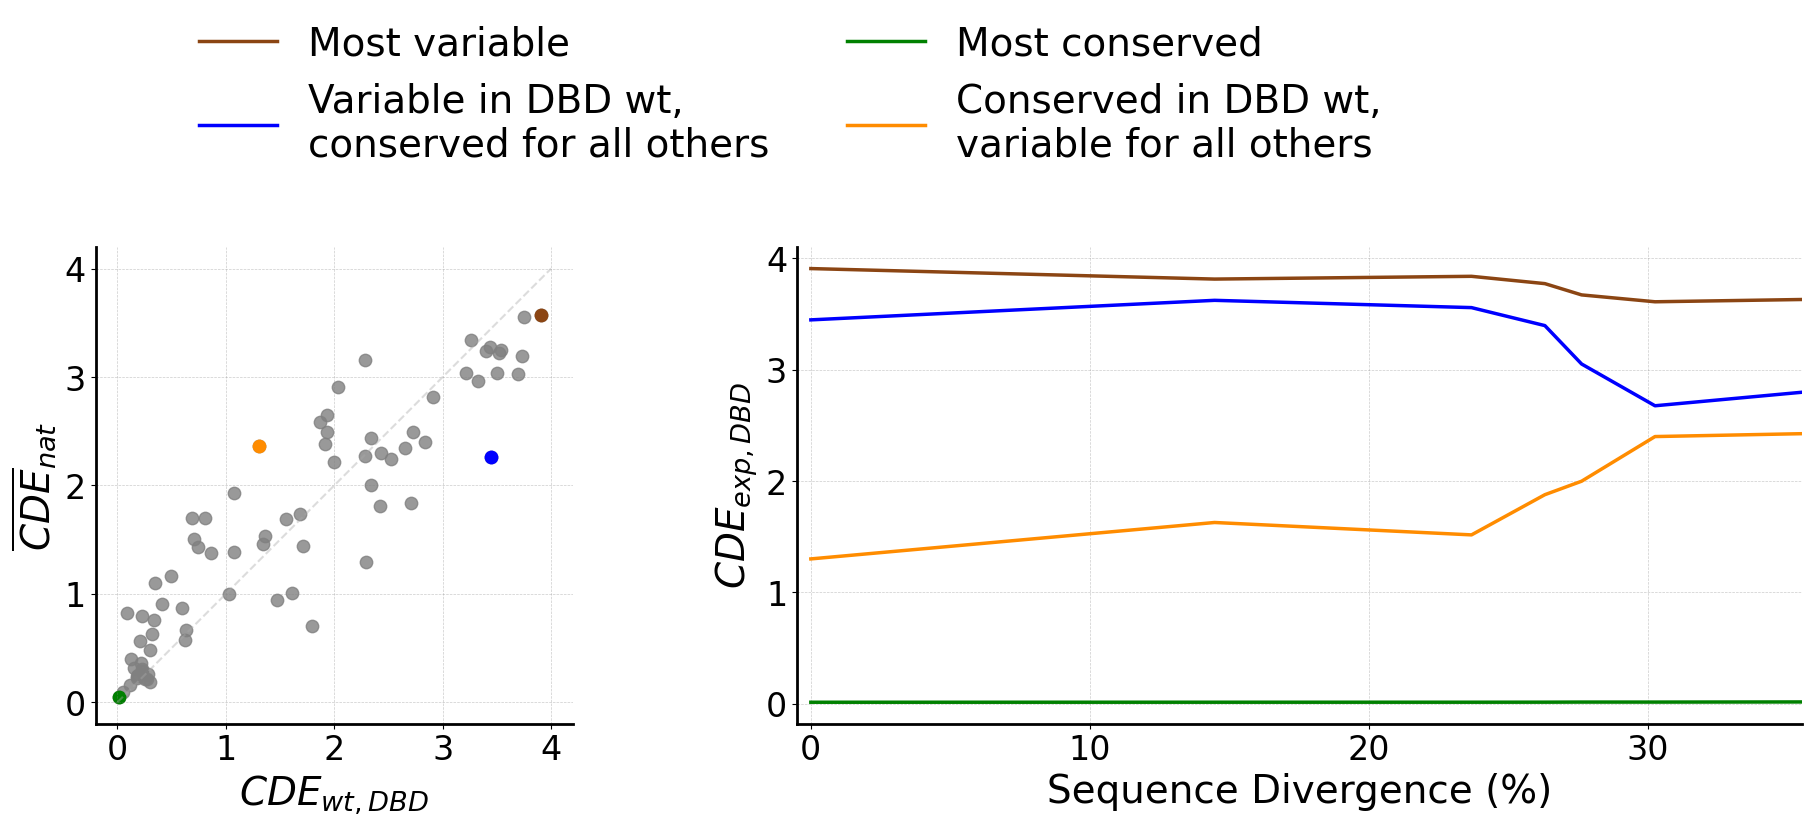

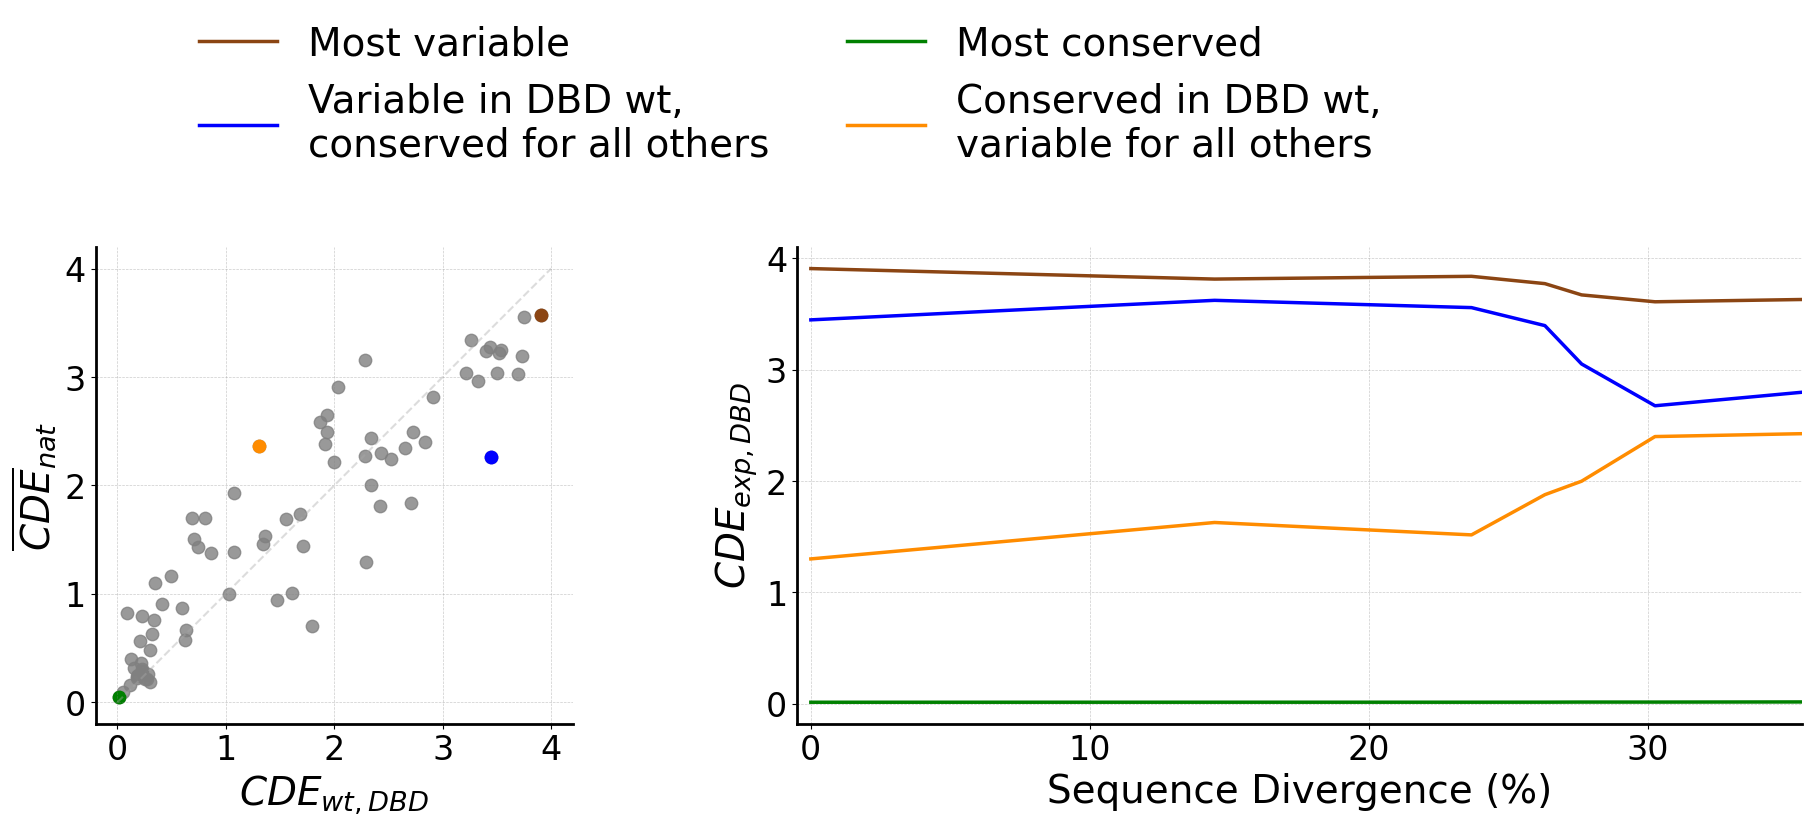

In [16]:
close("all")

pointsize = 80
transp = 0.8
transp2 = 1
d_from_neg_bisec = (cde_wt .+ cde_dbd .- 2) ./ sqrt(2)
lab = [0,1,2,3,4]
lab2 = [0, 10, 20, 30]
axis_width = 2.

ticks_font = 24
axis_font = 28

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(20)
 
ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0), colspan = 1)
ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 1), colspan = 1)

fig.subplots_adjust(wspace=0.1)

ax1.plot([0, 4.0], [0, 4.0], linestyle="--", alpha = 0.4, color = "darkgrey")
ax1.scatter(cde_wt, cde_dbd, color = "grey", s = pointsize, alpha = transp)
ax1.scatter(cde_wt[argmax(d_from_neg_bisec)], cde_dbd[argmax(d_from_neg_bisec)], color = "saddlebrown", s = pointsize, alpha = transp2)
ax1.scatter(cde_wt[argmax(cde_dbd .- cde_wt)], cde_dbd[argmax(cde_dbd .- cde_wt)], color = "darkorange",  s = pointsize, alpha = transp2)
ax1.scatter(cde_wt[argmin(d_from_neg_bisec)], cde_dbd[argmin(d_from_neg_bisec)], color = "green",  s = pointsize, alpha = transp2 )
ax1.scatter(cde_wt[argmin(cde_dbd .- cde_wt)], cde_dbd[argmin(cde_dbd .- cde_wt)], color = "blue",  s = pointsize, alpha = transp2 )
ax1.set_xticks([0,1,2,3,4])
ax1.set_yticks([0,1,2,3,4])
ax1.set_xticklabels(lab, fontsize = ticks_font)
ax1.set_yticklabels(lab, fontsize = ticks_font)
ax1.spines["top"].set_visible(false)
ax1.spines["right"].set_visible(false)
ax1.spines["left"].set_linewidth(axis_width)
ax1.spines["bottom"].set_linewidth(axis_width)
ax1.set_aspect("equal")
ax1.set_xlabel("\$CDE_{wt,DBD}\$", fontsize=axis_font)
ax1.set_ylabel("\$\\overline{CDE}_{nat}\$", fontsize=axis_font)
ax1.grid(color = "grey", linestyle = "--", linewidth = 0.5, alpha = 0.4)


y1 = cde_exp[:, argmax(d_from_neg_bisec)] #var
y2 = cde_exp[:, argmin(cde_dbd .- cde_wt)] #much more variable in pse, conserved in all others
y3 = cde_exp[:, argmin(d_from_neg_bisec)]  #cons
y4 = cde_exp[:, argmax(cde_dbd .- cde_wt)]  #much more conserved in pse, variable in all others


spessore = 2.5

ax2.plot(wt_dist, y1, linewidth = spessore, color = "saddlebrown", label = "Most variable")
ax2.plot(wt_dist, y2, linewidth = spessore, color = "blue", label = "Variable in DBD wt,\nconserved for all others")
ax2.plot(wt_dist, y3, linewidth = spessore, color = "green", label = "Most conserved")
ax2.plot(wt_dist, y4, linewidth = spessore, color = "darkorange", label = "Conserved in DBD wt,\nvariable for all others")

ax2.grid(color = "grey", linestyle = "--", linewidth = 0.5, alpha = 0.4)
ax2.set_xlabel("Sequence Divergence (%)", fontsize=axis_font)
ax2.set_ylabel("\$CDE_{exp,DBD}\$", fontsize=axis_font)
ax2.set_xticks(lab2)
ax2.set_yticks(lab)
ax2.set_xticklabels(lab2, fontsize = ticks_font)
ax2.set_yticklabels(lab, fontsize = ticks_font)
ax2.set_xlim(-0.5,maximum(wt_dist))
ax2.spines["top"].set_visible(false)
ax2.spines["right"].set_visible(false)
ax2.spines["left"].set_linewidth(axis_width)
ax2.spines["bottom"].set_linewidth(axis_width)


tight_layout()
fig.legend(loc="upper right", fontsize = axis_font, frameon = false, ncol = 2, bbox_to_anchor=(0.8, 1.4))


savefig(raw"../data/figures/suppl_DBD.png", dpi = 300, bbox_inches="tight")
gcf()

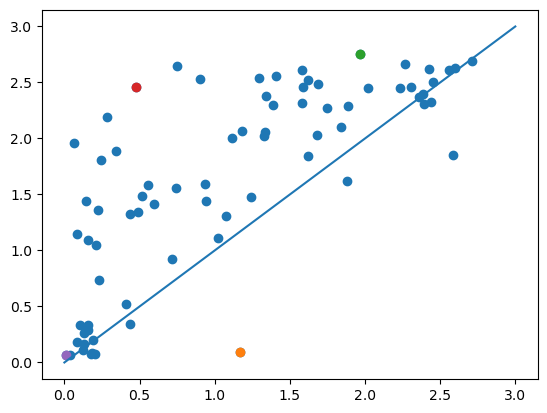

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2991b49610>

In [33]:
scatter(cde_wt, cie_dbd)
scatter(cde_wt[76], cie_dbd[76])
scatter(cde_wt[52], cie_dbd[52])
scatter(cde_wt[9], cie_dbd[9])
scatter(cde_wt[1], cie_dbd[1])
plot([0,3], [0,3])


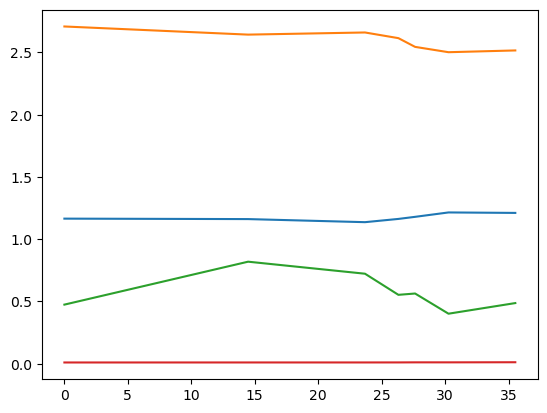

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2991c2a6a0>

In [27]:
plot(wt_dist, cde_exp[:, 76])
plot(wt_dist, cde_exp[:, 48])
plot(wt_dist, cde_exp[:, 9])
plot(wt_dist, cde_exp[:, 1])


In [22]:
cde_exp

7×76 adjoint(::Matrix{Float64}) with eltype Float64:
 0.00984186  2.30428  0.232739  …  2.58474  1.07573  0.413043  1.16537
 0.0100014   2.2851   0.370978     2.68046  1.21693  0.456275  1.16172
 0.010062    2.23042  0.537998     2.65509  1.37349  0.407013  1.13698
 0.0102935   2.09079  0.76946      2.60404  1.58517  0.4882    1.16307
 0.0109076   2.11759  0.786173     2.61881  1.61397  0.548579  1.17982
 0.0108394   2.09238  0.753062  …  2.60623  1.86304  0.559861  1.21513
 0.0117338   2.14549  0.733352     2.57323  1.81106  0.439219  1.21136

## DMS on non mutated sites

In [11]:
ref = wt_thornton
n_steps = 50
n_chains = 66
@time nm, l_nm, u_nm = mediate_on_chains_non_mut(n_chains, matrices, ref,
    n_steps, tot_E2F)
;

(54, 76)
(54, 76)
(54, 76)
(55, 76)
(53, 76)
(54, 76)
(54, 76)
(52, 76)
(51, 76)
(54, 76)
(56, 76)
(54, 76)
(57, 76)
(55, 76)
(55, 76)
(54, 76)
(55, 76)
(56, 76)
(55, 76)
(55, 76)
(55, 76)
(53, 76)
(56, 76)
(52, 76)
(53, 76)
(55, 76)
(53, 76)
(56, 76)
(54, 76)
(55, 76)
(54, 76)
(56, 76)
(55, 76)
(53, 76)
(57, 76)
(56, 76)
(54, 76)
(53, 76)
(52, 76)
(52, 76)
(51, 76)
(56, 76)
(54, 76)
(52, 76)
(53, 76)
(55, 76)
(55, 76)
(56, 76)
(55, 76)
(54, 76)
(56, 76)
(55, 76)
(51, 76)
(55, 76)
(56, 76)
(54, 76)
(52, 76)
(53, 76)
(54, 76)
(56, 76)
(56, 76)
(55, 76)
(54, 76)
(52, 76)
(56, 76)
(56, 76)
1372.493481 seconds (77.85 M allocations: 1.387 TiB, 0.73% gc time, 0.10% compilation time)


In [12]:
writedlm("../data/figures/data_fig5/nm", nm)
writedlm("../data/figures/data_fig5/u_nm", u_nm)
writedlm("../data/figures/data_fig5/l_nm", l_nm)

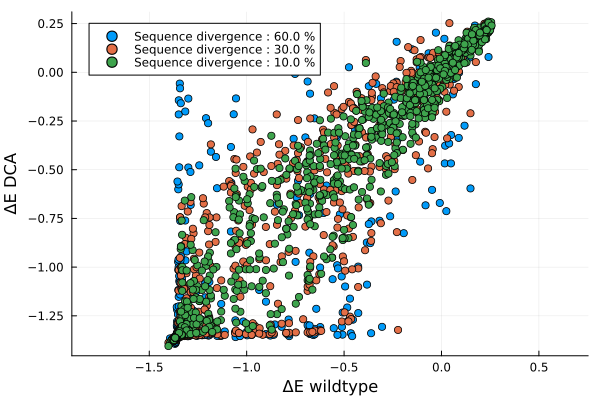

In [13]:
ref = wt_thornton
a = plot()
for i in [46, 23, 8]
    seq = matrices[1][i, :]
    dms_ref, dms_seq, d = get_energy_dms_scatter_non_mut(seq, ref, h, J)
    dms_ref = [map_dict(x, tot_E2F) for x in dms_ref]
    dms_seq = [map_dict(x, tot_E2F) for x in dms_seq]
    #println((length(dms_ref), length(dms_seq)))
    writedlm("../data/figures/data_fig5/dms_ref$d", dms_ref)
    writedlm("../data/figures/data_fig5/dms_seq$d", dms_seq)
    scatter!(a, dms_ref, dms_seq,
        aspect_ratio=:equal, label = "Sequence divergence : $d %",
        xlabel = "ΔE wildtype", ylabel = "ΔE DCA", legend=:topleft)
end
display(a)    

In [14]:
ref = wt_thornton
time_points = [5*i for i in 1:10] 
@time std_ddE_nonmut = hcat([[get_std_dms_scatter_non_mut(matrices[n][i,:], ref, 
        h, J, tot_E2F) for i in time_points] for n in 1:20]...)
;

 82.406496 seconds (4.56 M allocations: 85.222 GiB, 0.61% gc time, 0.36% compilation time)


In [15]:
m_std_ddE_nonmut = median(std_ddE_nonmut, dims = 2)
u_std_ddE_nonmut = matrix_quantiles(std_ddE_nonmut, 0.75, 2)
l_std_ddE_nonmut = matrix_quantiles(std_ddE_nonmut, 0.25, 2)
;

In [16]:
writedlm("../data/figures/data_fig5/reduced_d", time_points ./ 0.76)
writedlm("../data/figures/data_fig5/m_std_dde_nonmut", m_std_ddE_nonmut)
writedlm("../data/figures/data_fig5/u_std_dde_nonmut", u_std_ddE_nonmut)
writedlm("../data/figures/data_fig5/l_std_dde_nonmut", l_std_ddE_nonmut)

## Amino reversion on mutated sites

In [17]:
ref = wt_thornton
corr = []
abund = [] 
mean_distance = []
std_distance = []
std_dde = []


n = minimum([length(matrices[i][3:end,1]) for i in 1:length(matrices)])
println(n)

for i in 1:66
    a,b,c,e,f,g = get_info_on_epistatic_ab(matrices[i][3:end,:], ref, 
        h, J, n, tot_E2F)
    
    push!(corr, a)
    push!(abund, b)
    push!(mean_distance, e)
    push!(std_distance, f)
    push!(std_dde, g)
end

49


In [18]:
Abund = median(hcat(abund...), dims=2)[:]
u_Abund = matrix_quantiles(hcat(abund...), 0.75, 2)[:]
l_Abund = matrix_quantiles(hcat(abund...), 0.25, 2)[:]

median_Distance = median(hcat(mean_distance...), dims=2)[:]
l_Distance = matrix_quantiles(hcat(mean_distance...), 0.25, 2)[:]
u_Distance = matrix_quantiles(hcat(mean_distance...), 0.75, 2)[:]

m = median(hcat(corr...), dims=2)[:]
u_m = matrix_quantiles(hcat(corr...), 0.25, 2)[:]
l_m = matrix_quantiles(hcat(corr...), 0.75, 2)[:]

m_std_dde_mut = median(hcat(std_dde...), dims=2)[:]
l_std_dde_mut = matrix_quantiles(hcat(std_dde...), 0.25, 2)[:]
u_std_dde_mut = matrix_quantiles(hcat(std_dde...), 0.75, 2)[:]
;

In [19]:
#writedlm("../data/figures/data_fig5/median_d", median_Distance)
writedlm("../data/figures/data_fig5/median_abund", Abund)
#writedlm("../data/figures/data_fig5/u_d", u_Distance)
#writedlm("../data/figures/data_fig5/l_d", l_Distance)
writedlm("../data/figures/data_fig5/u_abund", u_Abund)
writedlm("../data/figures/data_fig5/l_abund", l_Abund)
;

In [20]:
writedlm("../data/figures/data_fig5/m", m)
writedlm("../data/figures/data_fig5/u_m", u_m)
writedlm("../data/figures/data_fig5/l_m", l_m)
writedlm("../data/figures/data_fig5/d", [i for i in 1:n_steps-1] ./0.76)
writedlm("../data/figures/data_fig5/m_std_dde_mut", m_std_dde_mut)
writedlm("../data/figures/data_fig5/l_std_dde_mut", l_std_dde_mut)
writedlm("../data/figures/data_fig5/u_std_dde_mut", u_std_dde_mut)
;

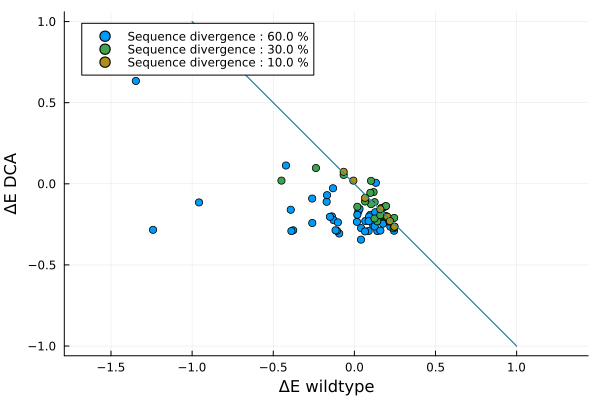

In [21]:
ref = wt_thornton
c = plot()
for i in [46, 23, 8]
    mask = ref .!= matrices[1][i,:]
    seq = matrices[1][i, :]
    a, b, E_ref, E_seq = get_muts_deltas(mask, ref, seq, h, J)
    E_ref = [map_dict(x, tot_E2F) for x in E_ref]
    E_seq = .-[map_dict(-x, tot_E2F) for x in E_seq]
    L = length(seq)
    d = 100 * round.(KitMSA.my_hamming(ref, seq)/L, digits = 1)
    writedlm("../data/figures/data_fig5/E_ref$d", E_ref)
    writedlm("../data/figures/data_fig5/E_seq$d", E_seq)
    scatter!(c, E_ref, E_seq, aspect_ratio=:equal, 
        label = "Sequence divergence : $d %",
        xlabel = "ΔE wildtype", ylabel = "ΔE DCA", legend=:topleft)
    plot!(c, [1,-1], [-1,1], label ="")
end
display(c)
    

## Part on thornton experiments

In [22]:
function extract_wts(df)
    wt = []
    wt1 = []
    site_vec = df.SITE
    l = length(site_vec)
    for (i, s) in enumerate(site_vec[1:(l - 1)])
        if site_vec[i+1] != site_vec[i] || i == (l - 1)
            append!(wt, df.WTAA[i])
            append!(wt1, df.WTAA_1[i])
        end
    end
    
    return wt, wt1
end

function get_epistatic_variance(df; tomap = false)
    if tomap
        return var(map_01.(df.FIT) - map_01.(df.FIT_1))
    else
        return var(df.FIT - df.FIT_1)
    end
end

function get_hamming_distance(df)
    wt, wt1 = extract_wts(df)
    return KitMSA.my_hamming(wt, wt1)/length(wt)
end


function get_correlation_fitness(df; tomap = false)
    if tomap
        return cor(df.FIT, df.FIT_1) 
    else
        return cor(map_01(df.FIT), map_01(df.FIT_1))
    end
end


function get_correlation_fitness2(df)
    return cor(df.FIT, df.FIT_1) 
end

function map_01(vec)
    minn = minimum(vec)
    maxx = maximum(vec)
    return (vec .- minn)./(maxx - minn)
end

function get_df_corr_nonmut(dms1, dms2)
    df_unique_all = dropmissing!(innerjoin(dms1, dms2, on = [:SITE, :MTAA], 
                makeunique=true))
    joe_pair_dfs = df_unique_all    
    real_pairs_dfs = df_unique_all[df_unique_all[:, 3] .== df_unique_all[:, 8], :]
    
    d = 100 * get_hamming_distance(joe_pair_dfs)
    #corr = get_correlation_fitness(real_pairs_dfs)
    corr = get_correlation_fitness2(real_pairs_dfs)
    return d, corr
end

function get_df_corr_mut(dms1, dms2)
    df_unique_all = dropmissing!(innerjoin(dms1, dms2, on = [:SITE], 
                makeunique=true))
    joe_pair_dfs = df_unique_all    
    real_pairs_dfs = df_unique_all[(df_unique_all[:, 4] .== df_unique_all[:, 8]) .&&
    (df_unique_all[:, 3] .== df_unique_all[:, 9]) .&&
    (df_unique_all[:, 3] .!= df_unique_all[:, 8]), :]
    
    d = 100 * get_hamming_distance(joe_pair_dfs)
    corr = get_correlation_fitness2(real_pairs_dfs)
    return d, corr
end

function get_df_epis_ab_mut(dms1, dms2)
    df_unique_all = dropmissing!(innerjoin(dms1, dms2, on = [:SITE], 
                makeunique=true))
    joe_pair_dfs = df_unique_all    
    real_pairs_dfs = df_unique_all[(df_unique_all[:, 4] .== df_unique_all[:, 8]) .&&
    (df_unique_all[:, 3] .== df_unique_all[:, 9]) .&&
    (df_unique_all[:, 3] .!= df_unique_all[:, 8]), :]
    
    d = 100 * get_hamming_distance(joe_pair_dfs)
    arr1 = real_pairs_dfs.FIT
    arr2 = real_pairs_dfs.FIT_1
    ab = sum(arr1 .<0 .&& arr2 .<0) / length(arr1)
    return d, ab
end

function get_df_fitness_mut(dms1, dms2)
    df_unique_all = dropmissing!(innerjoin(dms1, dms2, on = [:SITE], 
                makeunique=true))
    joe_pair_dfs = df_unique_all    
    real_pairs_dfs = df_unique_all[(df_unique_all[:, 4] .== df_unique_all[:, 8]) .&&
    (df_unique_all[:, 3] .== df_unique_all[:, 9]) .&&
    (df_unique_all[:, 3] .!= df_unique_all[:, 8]), :]
    
    d = 100 * get_hamming_distance(joe_pair_dfs)
    dF_ref = real_pairs_dfs.FIT
    dF_seq = real_pairs_dfs.FIT_1
    return dF_ref, dF_seq
end

function get_df_epis_var_mut(dms1, dms2)
    df_unique_all = dropmissing!(innerjoin(dms1, dms2, on = [:SITE], 
                makeunique=true))
    joe_pair_dfs = df_unique_all    
    real_pairs_dfs = df_unique_all[(df_unique_all[:, 4] .== df_unique_all[:, 8]) .&&
    (df_unique_all[:, 3] .== df_unique_all[:, 9]) .&&
    (df_unique_all[:, 3] .!= df_unique_all[:, 8]), :]
    
    d = 100 * get_hamming_distance(joe_pair_dfs)
    dde_var = std(real_pairs_dfs.FIT .+ real_pairs_dfs.FIT_1) 
    return d, dde_var
end

function get_df_epis_var_nonmut(dms1, dms2)
    df_unique_all = dropmissing!(innerjoin(dms1, dms2, on = [:SITE, :MTAA], 
                makeunique=true))
    joe_pair_dfs = df_unique_all    
    real_pairs_dfs = df_unique_all[df_unique_all[:, 3] .== df_unique_all[:, 8], :]
    
    d = 100 * get_hamming_distance(joe_pair_dfs)
    dde_var = std(real_pairs_dfs.FIT .- real_pairs_dfs.FIT_1) 
    return d, dde_var
end

get_df_epis_var_nonmut (generic function with 1 method)

In [23]:
nwt = length(sel_wt_MAP_1)
npair = div(nwt*(nwt-1), 2)                
np = div(nwt*(nwt - 1), 2)
#joe_DCA_pair_dfs = [DataFrame() for _ in 1:npair]
dis = zeros(np)
corr_nm_exp = zeros(np)
corr_m_exp = zeros(np)
s_dde_m_exp = zeros(np)
s_dde_nm_exp = zeros(np)
ab_m_exp = zeros(np)

k = 0
for i in 1:7
    for j in (i+1):7
        k+=1
        
        # experiment
        ind1 = sel_wt_MAP_1[i]
        ind2 = sel_wt_MAP_1[j]
        dms1 = df[  df[:, "PROT"] .== ind1, :]
        dms2 = df[  df[:, "PROT"] .== ind2, :]
        
        d, corr = get_df_corr_nonmut(dms1, dms2)
        d, corr2 = get_df_corr_mut(dms1, dms2)
        d, dde_m = get_df_epis_var_mut(dms1, dms2)
        d, dde_nm = get_df_epis_var_nonmut(dms1, dms2)
        d, ep_ab = get_df_epis_ab_mut(dms1, dms2)
        dis[k] = d 
        corr_nm_exp[k] = corr
        corr_m_exp[k] = corr2
        s_dde_m_exp[k] = dde_m
        s_dde_nm_exp[k] = dde_nm
        ab_m_exp[k] = ep_ab
    end
end

In [24]:
ind1 = sel_wt_MAP_1[2]
ind2 = sel_wt_MAP_1[3]
dms1 = df[  df[:, "PROT"] .== ind1, :]
dms2 = df[  df[:, "PROT"] .== ind2, :]
dF_ref10, dF_seq10 = get_df_fitness_mut(dms1, dms2)

ind1 = sel_wt_MAP_1[1]
ind2 = sel_wt_MAP_1[6]
dms1 = df[  df[:, "PROT"] .== ind1, :]
dms2 = df[  df[:, "PROT"] .== ind2, :]
dF_ref30, dF_seq30 = get_df_fitness_mut(dms1, dms2)
;

In [25]:
writedlm("../data/figures/data_fig5/dF_ref30.0", dF_ref30)
writedlm("../data/figures/data_fig5/dF_seq30.0", dF_seq30)
writedlm("../data/figures/data_fig5/dF_ref10.0", dF_ref10)
writedlm("../data/figures/data_fig5/dF_seq10.0", dF_seq10)
;

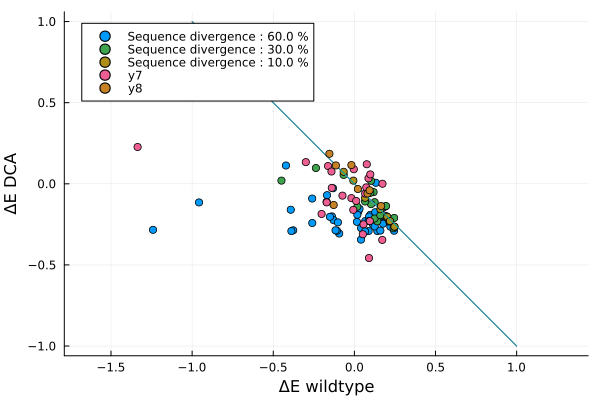

In [26]:
ref = wt_thornton
c = plot()
for i in [46, 23, 8]
    mask = ref .!= matrices[1][i,:]
    seq = matrices[1][i, :]
    a, b, E_ref, E_seq = get_muts_deltas(mask, ref, seq, h, J)
    E_ref = [map_dict(x, tot_E2F) for x in E_ref]
    E_seq = .-[map_dict(-x, tot_E2F) for x in E_seq]
    L = length(seq)
    d = 100 * round.(KitMSA.my_hamming(ref, seq)/L, digits = 1)
    #writedlm("../data/figures/data_fig5/E_ref$d", E_ref)
    #writedlm("../data/figures/data_fig5/E_seq$d", E_seq)
    scatter!(c, E_ref, E_seq, aspect_ratio=:equal, 
        label = "Sequence divergence : $d %",
        xlabel = "ΔE wildtype", ylabel = "ΔE DCA", legend=:topleft)
    plot!(c, [1,-1], [-1,1], label ="")
end
scatter!(c, dF_ref30, dF_seq30)
scatter!(c, dF_ref10, dF_seq10)
display(c)
    

In [27]:
writedlm("../data/figures/data_fig5/d_exp", dis)
writedlm("../data/figures/data_fig5/corr_nm_exp", corr_nm_exp)
writedlm("../data/figures/data_fig5/corr_m_exp", corr_m_exp)
writedlm("../data/figures/data_fig5/s_dde_nm_exp", s_dde_nm_exp)
writedlm("../data/figures/data_fig5/s_dde_m_exp", s_dde_m_exp)
writedlm("../data/figures/data_fig5/ab_m_exp", ab_m_exp)